# Expectation Maximization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Read csv files containing features extracted from flower images

In [2]:
butterfly_peas = pd.read_csv('butterflypea_features.csv')
chrysanthemum = pd.read_csv('chrysanthemum_features.csv')
rose = pd.read_csv('rose_features.csv')

In [3]:
data = butterfly_peas.append(chrysanthemum,ignore_index=True)
data = data.append(rose,ignore_index=True).drop(columns='Unnamed: 0')

### Generate a Gaussian function

In [5]:
def generate_gaussian():
    mu = np.random.rand(2)
    std = np.random.rand(2,2)  
    
    return mu,std

###  Generate 2D Gaussian probability

In [6]:
def gaussian_2d(mu,std,features):
    
    coeff = 1/(2*np.pi*(np.linalg.det(std)**2))
    exponent = -(np.asmatrix(features-mu)@np.asmatrix(np.linalg.inv(std))@np.asmatrix((features-mu)).T)

    return coeff*np.exp(np.array(exponent)/2)

## Probability of each data point given the parameters

In [7]:
def probability(sample,mu,std):
    g = sample['g']
    e = sample['eccentricity']
    features = np.array([g,e])
    
    return gaussian_2d(mu,std,features)[0][0]

## Probability of class l given data point xi and parameters

In [8]:
def prob_of_l(P,sample,mu,std):
    Pl_given_x = []
    
    p_l1 = probability(sample,mu[0],std[0]) #gaussian component pdf 
    p_l2 = probability(sample,mu[1],std[1]) #gaussian component pdf 
    p_l3 = probability(sample,mu[2],std[2]) #gaussian component pdf 

    prob = P*np.array([p_l1,p_l2,p_l3])
    Pl_given_x = prob/np.sum(prob)
    
    return Pl_given_x

## New prior probability

In [9]:
def new_prob(P,mu,std):
    prob_l = []
    
    for k in range(len(data)):
        prob_l.append(prob_of_l(P,data.iloc[k],mu,std))
    
    return np.sum(np.array(prob_l),axis=0)/len(data)

## New mean

In [10]:
def new_mean(P,mu,std):
    numerator1 = []
    numerator2 = []
    numerator3 = []
    
    denominator = []
    for j in range(len(data)):
        sample = data.iloc[j]
        
        prob_l = prob_of_l(P,sample,mu,std)
        denominator.append(prob_l)
        
        X = np.array([sample['g'],sample['eccentricity']])
        numerator1.append(X*prob_l[0])
        numerator2.append(X*prob_l[1])
        numerator3.append(X*prob_l[2])
    
    denominator = np.array(denominator)
        
    new_mu1 = np.sum(numerator1,axis=0)/np.sum(denominator[:,0])
    new_mu2 = np.sum(numerator2,axis=0)/np.sum(denominator[:,1])
    new_mu3 = np.sum(numerator3,axis=0)/np.sum(denominator[:,2])
    
    return np.array([new_mu1,new_mu2,new_mu3])

## New standard deviation

In [11]:
def new_std(P,mu_new,mu,std):
    numerator1 = []
    numerator2 = []
    numerator3 = []
    
    denominator = []

    for s in range(len(data)):
        sample = data.iloc[s]
        prob_l = prob_of_l(P,sample,mu,std)
        denominator.append(prob_l)
        
        X = np.array([sample['g'],sample['eccentricity']])
        difference1 = np.asmatrix(X-mu_new[0])
        difference2 = np.asmatrix(X-mu_new[1])
        difference3 = np.asmatrix(X-mu_new[2])
        
        numerator1.append(np.array(prob_l[0]*difference1.T@difference1))
        numerator2.append(np.array(prob_l[1]*difference2.T@difference2))
        numerator3.append(np.array(prob_l[2]*difference3.T@difference3))
        
    denominator = np.array(denominator)
    
    new_std1 = np.sum(numerator1,axis=0)/np.sum(denominator[:,0])
    new_std2 = np.sum(numerator2,axis=0)/np.sum(denominator[:,1])
    new_std3 = np.sum(numerator3,axis=0)/np.sum(denominator[:,2])

    return np.array([new_std1,new_std2,new_std3])

## Stopping Condition

In [12]:
def stopping_condition(old,new):
    threshold = 0.01
    diff = np.abs(new-old)
    if diff.all() > threshold:
        return True
    else:
        return False

## Main Expectation Maximization Algorithm

In [13]:
# np.random.seed()

mu1_old,std1_old = generate_gaussian()
mu2_old = generate_gaussian()[0]
mu3_old = generate_gaussian()[0]

std2_old = std1_old
std3_old = std1_old

M = 4 #number of classes
P_old = np.array(3*[1/M]) #prior probability

mu_old = np.array([mu1_old,mu2_old,mu3_old])
std_old = np.array([std1_old,std2_old,std3_old])

In [14]:
mu_new = new_mean(P_old,mu_old,std_old)
std_new = new_std(P_old,mu_new,mu_old,std_old)
P_new = new_prob(P_old,mu_old,std_old)
counter = 0
while True:
    P_old = P_new
    
    if stopping_condition(mu_old,mu_new):
        mu_old = mu_new
        mu_new = new_mean(P_new,mu_old,std_old)
        
    if stopping_condition(std_old,std_new):
        std_old = std_new
        std_new = new_std(P_new,mu_new,mu_old,std_old)
        
    else:
        break
    counter += 1
    P_new = new_prob(P_old,mu_old,std_old)

## Generate a heat map of the probability distribution function

In [15]:
x = np.linspace(0,1,100)
y = np.linspace(0,1,100)

In [16]:
z1 = np.zeros((len(x),len(y)))
z2 = np.zeros((len(x),len(y)))
z3 = np.zeros((len(x),len(y)))

for i in range(len(x)):
    for j in range(len(y)):
        xx = x[i]
        yy = y[j]
        z1[i][j] = gaussian_2d(mu_new[0],std_new[0],np.array([xx,yy]))[0][0]
        z2[i][j] = gaussian_2d(mu_new[1],std_new[1],np.array([xx,yy]))[0][0]        
        z3[i][j] = gaussian_2d(mu_new[2],std_new[2],np.array([xx,yy]))[0][0]        

In [17]:
z1 = z1/np.amax(z1)
z2 = z2/np.amax(z2)
z3 = z3/np.amax(z3)

## Overlay scatterplot of flower features over generate PDF heatmap

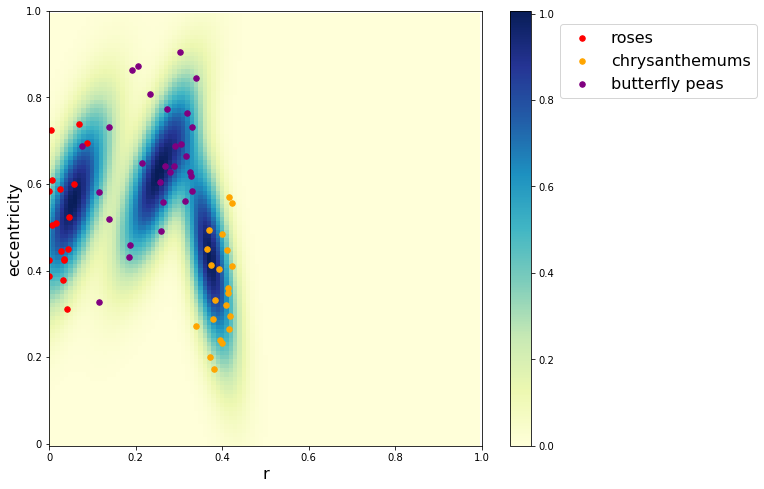

In [18]:
plt.figure(figsize=(10,8))

plt.imshow((z1+z2+z3).T,origin='lower',cmap='YlGnBu')
plt.colorbar()

plt.scatter(100*rose['g'],100*rose['eccentricity'],c='red',s=30,label='roses')
plt.scatter(100*chrysanthemum['g'],100*chrysanthemum['eccentricity'],c='orange',s=30,label='chrysanthemums')
plt.scatter(100*butterfly_peas['g'],100*butterfly_peas['eccentricity'],c='purple',s=30,label='butterfly peas')

plt.xticks(np.arange(0,120,20),['0','0.2','0.4','0.6','0.8','1.0'])
plt.yticks(np.arange(0,120,20),['0','0.2','0.4','0.6','0.8','1.0'])
plt.xlim(0,100)
plt.ylabel('eccentricity',fontsize=16)
plt.xlabel('r',fontsize=16)
plt.legend(loc=(1.18,0.8),fontsize=16)

# plt.savefig('gvse_P4.png',dpi=300,bbox_inches='tight')
plt.show()